In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from typing import List, Dict
from datetime import datetime, timedelta
sns.set_theme(style="darkgrid")

In [307]:
df_web = pd.read_csv('data/event_data_20220217-20220314.csv')
df_web['hour'] = pd.to_datetime(df_web['request_time']).dt.hour
df_unique_users = df_web.groupby(by=['fingerprint']).first()

df_facebook_reach = pd.read_csv('data/facebook_reach.csv', encoding = "utf-8")
df_instagram_reach = pd.read_csv('data/instagram_reach.csv', encoding = "utf-8")

df_facebook_pageviews = pd.read_csv('data/facebook_pageviews.csv', encoding = "utf-8")
df_instagram_pageviews = pd.read_csv('data/instagram_pageviews.csv', encoding = "utf-8")


In [320]:
# CALC: Sessioner Hemsida korrelation Facebook, Instagram Räckvidd

social_media_preproc = pd.DataFrame({
    'Hemsida Sessioner': list(df_sessions_per_day),
    'Facebook Räckvidd': df_facebook_reach['reach'],
    'Instagram Räckvidd': df_instagram_reach['reach'],
    'Facebook Sidvisningar': df_facebook_pageviews['pageviews'],
    'Instagram Sidvisningar': df_instagram_pageviews['pageviews'],
})
social_media_norm = (social_media_preproc-social_media_preproc.mean())/social_media_preproc.std()
social_media_norm['Datum'] = date_days

facebook_correlation = social_media_norm.drop(columns=['Instagram Räckvidd', 'Instagram Sidvisningar'])
instagram_correlation = social_media_norm.drop(columns=['Facebook Räckvidd', 'Facebook Sidvisningar'])


In [309]:
# CALC: Sidvisningar, Sessioner, Unika Användare över Datum

df_total_events_per_day = df_web.groupby(by=['date_day'], as_index=True).count()['event_id']
df_sessions_per_day = df_web.where((df_web['event_number'] == 1)) \
    .groupby(by=['date_day'], as_index=True).count()['session_id']
df_unique_users_per_day = df_web.groupby(by=['date_day'], as_index=True).fingerprint.nunique()
date_days = sorted(df_web['date_day'].unique())
weekdays = [datetime.strptime(e, "%Y-%m-%d").date().weekday() for e in date_days]


date_preproc = pd.DataFrame({
    'Datum': date_days,
    'Veckodag': weekdays,
    'Sidvisningar': df_total_events_per_day,
    'Sessioner': df_sessions_per_day,
    'Unika Användare': df_unique_users_per_day
})
    

In [310]:
# CALC: Sidvisningar, Sessioner över Tid på dygnet

df_mean_events_per_hour = df_web.groupby(by=['date_day', 'hour'], as_index=True).count() \
    .groupby(by=['hour'], as_index=True).mean()['event_id']
df_mean_sessions_per_hour = df_web.where((df_web['event_number'] == 1)) \
    .groupby(by=['date_day', 'hour'], as_index=True).count() \
    .groupby(by=['hour'], as_index=True).mean()['session_id']


hour_preproc = pd.DataFrame({
    'Timme': range(24),
    'Sidvisningar': df_mean_events_per_hour,
    'Sessioner': df_mean_sessions_per_hour,
})


In [311]:
# CALC: Sidvisningar, Sessioner över Veckodag

weekdays_map = {
    0: 'Måndag',
    1: 'Tisdag',
    2: 'Onsdag',
    3: 'Torsdag',
    4: 'Fredag',
    5: 'Lördag',
    6: 'Söndag',
}

weekday_agg = day_preproc.groupby(by=['Veckodag'], as_index=True).agg({
    'Sidvisningar' : ['median', 'mean'],
    'Sessioner': ['median', 'mean'],
    'Unika Användare': ['median', 'mean'],
})

weekday_preproc = pd.DataFrame({
    'Veckodag': [e for e in weekdays_map.values()],
    'Sidvisningar': week_day_agg['Sidvisningar']['median'],
    'Sessioner': week_day_agg['Sessioner']['median'],
})


In [312]:
# CALC: Sidvisningar per Session

df_session_events = df_web.groupby(by=['session_id'], as_index=True) \
    .count()['event_id'].reset_index(name="event_count")
multiple_event_sessions = df_session_events.where((df_session_events['event_count'] > 1 )).dropna()
one_event_sessions = df_session_events.where((df_session_events['event_count'] == 1 )).dropna()

total_session_count = df_session_events['session_id'].count()
multiple_event_sessions_count = multiple_event_sessions['session_id'].count()
one_event_sessions_count = one_event_sessions['session_id'].count()

ONE_EVENT_SESSION_RATIO = round(100*(one_event_sessions_count/total_session_count), 2)

AVG_EVENTS_PER_SESSION = round(df_session_events['event_count'].mean(), 2)
AVG_EVENTS_PER_MULTIPLE_EVENT_SESSIONS = round(multiple_event_sessions['event_count'].mean(), 2)


In [313]:
# CALC: Tid per Session

multiple_event_sessions_events = multiple_event_sessions.set_index('session_id') \
    .join(df_web.set_index('session_id'), how='inner')
session_max_min_time = multiple_event_sessions_events.groupby(by=['session_id'], as_index=True) \
    .agg({'request_time' : ['min', 'max'], 'event_count': ['mean']})
session_max_min_time['session_time'] = pd.to_datetime(session_max_min_time['request_time']['max']) \
    - pd.to_datetime(session_max_min_time['request_time']['min'])

session_stats = session_max_min_time[['session_time', 'event_count']].median()

MED_TIME_PER_PAGE = round(float(df_web['seconds_to_next_event_in_session'].dropna().median()), 2)
MED_SESSION_TIME = round(float((session_stats['session_time'].dt.total_seconds() + MED_TIME_PER_PAGE)), 2)


# Sidvisningar, Sessioner & Unika Användare i snitt över datum

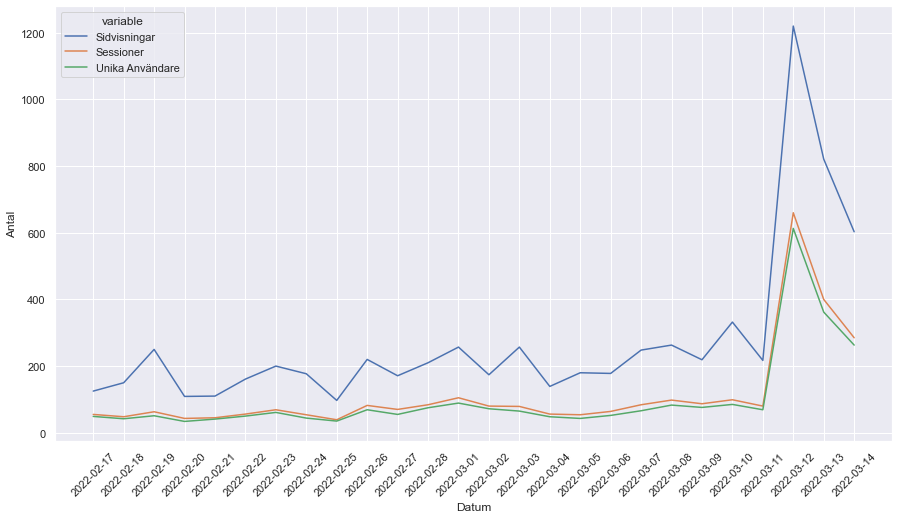

In [314]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
sns.lineplot(x='Datum', y='value', hue='variable', data=pd.melt(date_preproc.drop(columns=['Veckodag']), ['Datum']), ax=ax)
plt.xticks(rotation=45); plt.ylabel('Antal')
plt.show()

# Sidvisningar & Sessioner i snitt över veckodag

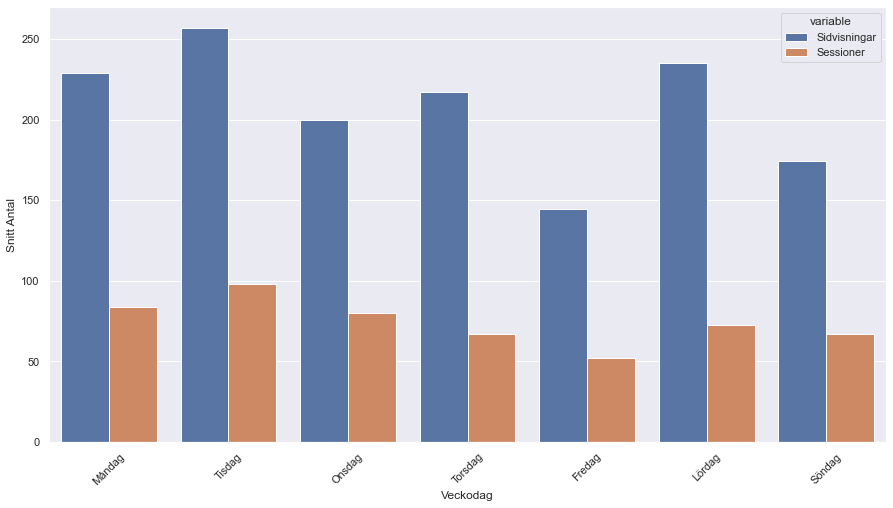

In [315]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
sns.barplot(x='Veckodag', y='value', hue='variable', data=pd.melt(weekday_preproc, ['Veckodag']), ax=ax)
plt.xticks(rotation=45); plt.ylabel('Snitt Antal')
plt.show()

# Sidvisningar & Sessioner i snitt över tid på dygnet

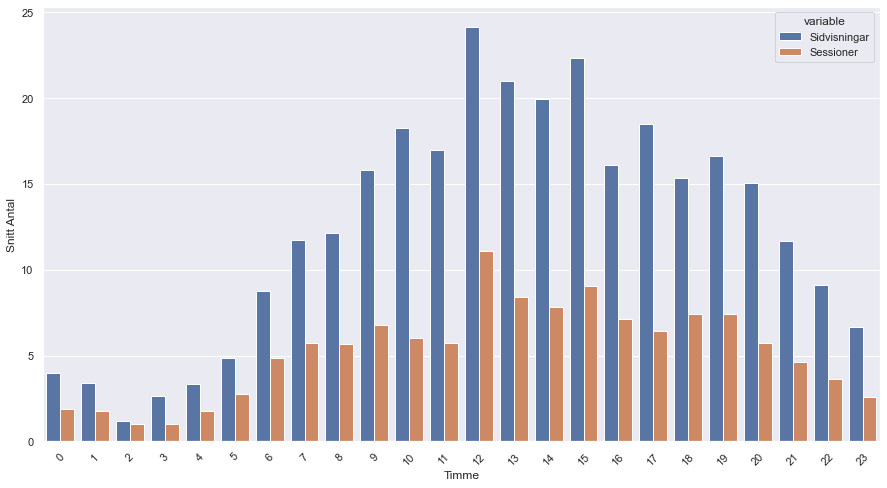

In [316]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
sns.barplot(x='Timme', y='value', hue='variable', data=pd.melt(hour_preproc, ['Timme']), ax=ax)
plt.xticks(rotation=45); plt.ylabel('Snitt Antal')
plt.show()

# Antal Sidvisningar och Sid-tid under Sessioner

In [324]:
print(f"""
Andel av sessioner där besökaren endast besökte en enskild sida:\t {ONE_EVENT_SESSION_RATIO}%
Antal sidor som besökare i snitt besöker under en session:\t\t {AVG_EVENTS_PER_SESSION} stycken
Antal sidor som besökare i snitt besöker under sessioner med 
    fler än en sidvisning:\t\t\t\t\t\t {AVG_EVENTS_PER_MULTIPLE_EVENT_SESSIONS} stycken

Snitt-tid som besökare spenderar
    på varje sida (median):\t\t\t {MED_TIME_PER_PAGE} sekunder
    på hemsidan under en session (median):\t {MED_SESSION_TIME} sekunder
""")


Andel av sessioner där besökaren endast besökte en enskild sida:	 55.12%
Antal sidor som besökare i snitt besöker under en session:		 2.41 stycken
Antal sidor som besökare i snitt besöker under sessioner med 
    fler än en sidvisning:						 4.15 stycken

Snitt-tid som besökare spenderar
    på varje sida (median):			 34.0 sekunder
    på hemsidan under en session (median):	 130.08 sekunder



# Hemsida Sessioner korrelation Facebook
Hur sessioner på Hemsidan korrelerar (sammanfaller) med Räckvidd och Sidvisningar på Facebook

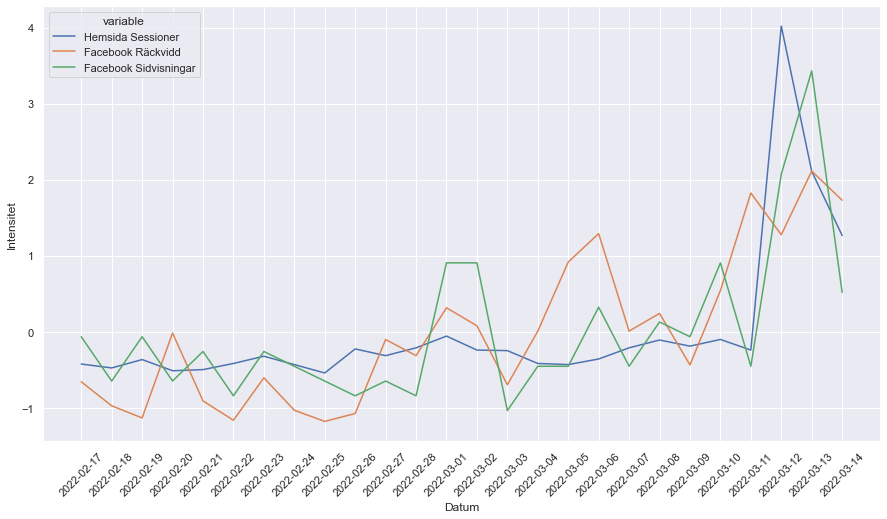

In [321]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
sns.lineplot(x='Datum', y='value', hue='variable', data=pd.melt(facebook_correlation, ['Datum']), ax=ax)
plt.xticks(rotation=45); plt.ylabel('Intensitet')
plt.show()

# Hemsida Sessioner korrelation Instagram
Hur sessioner på Hemsidan korrelerar (sammanfaller) med Räckvidd och Sidvisningar på Instagram

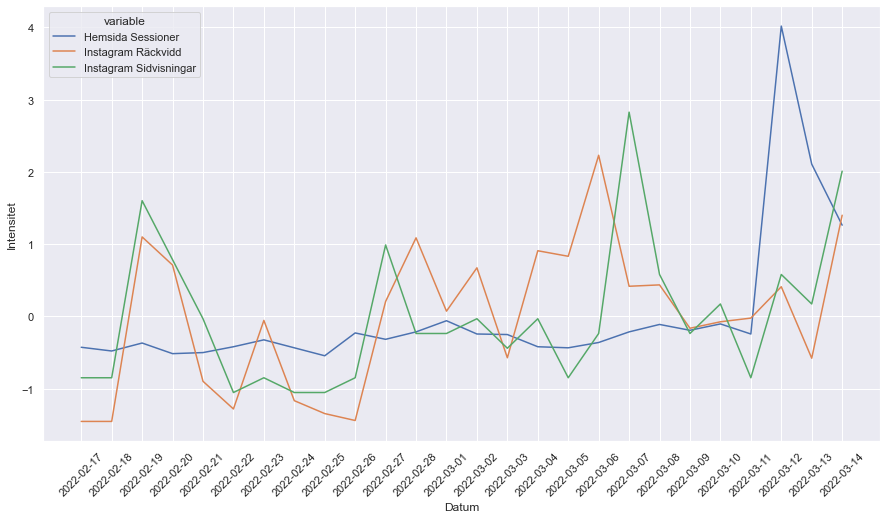

In [323]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
sns.lineplot(x='Datum', y='value', hue='variable', data=pd.melt(instagram_correlation, ['Datum']), ax=ax)
plt.xticks(rotation=45); plt.ylabel('Intensitet')
plt.show()